# Refactored simple nets

In [1]:
from setup import *
from generators import * 
from utils import *
from denoising_unet import *

2024-01-09 12:14:08.781223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 12:14:08.817407: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
import io
import cv2
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from keras import backend as K


In [3]:
batch_size = 32

In [4]:
high_path_2010_2019 = "data/wind_speed_italy_CERRA_2010-2019.npy"
high_path_2020 = "data/wind_speed_italy_CERRA_2020.npy"
high_path_2009 = "data/wind_speed_italy_CERRA_2009.npy"
high_path_balcans = "data/wind_speed_BALCANS_CERRA_2009.npy"


low_path_2010_2019 = "data/wind_speed_italy_ERA5_2010-2019.npy"
low_path_2020 = "data/wind_speed_italy_ERA5_2020.npy"
low_path_2009 = "data/wind_speed_italy_ERA5_2009.npy"
low_path_balcans = "data/wind_speed_BALCANS_ERA5_2009.npy"

In [5]:
train_generator = DataGeneratorMemmap(high_path_2010_2019,low_path_2010_2019, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2010_2019,sequential=False,
                                      batch_size = batch_size, unet = True)

test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=False,
                                      batch_size = batch_size, unet = True)

full_test_generator = DataGeneratorMemmap(high_path_2020,low_path_2020, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2020,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generator2009 = DataGeneratorMemmap(high_path_2009,low_path_2009, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

full_test_generatorBALCANS = DataGeneratorMemmap(high_path_balcans,low_path_balcans, 
                                      setup.max_high_res, setup.max_low_res, 
                                      setup.dataset_lenght_2009,sequential=True,
                                      batch_size = batch_size, unet = True)

### Training

In [6]:
unet_model = get_post_network(image_size, 4, 1, widths, block_depth)


optimizer=keras.optimizers.experimental.AdamW
unet_model.compile(
    optimizer=optimizer(
        learning_rate=1e-4, weight_decay=1e-5
    ),
    loss=tf.keras.losses.MeanSquaredError()
)

2024-01-09 12:14:09.732414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:14:09.746524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:14:09.747056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-09 12:14:09.747773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other 

In [7]:
unet_model.summary()

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 256, 64  128        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [8]:
def post_saver(epoch, logs):
    if(epoch % 10 == 0):
        unet_model.save_weights("weights/"+str(epoch)+"unet")

In [9]:
unet_model.load_weights("weights/110unet")

In [71]:
# run training and plot generated images periodically
unet_model.fit(
    train_generator,
    #initial_epoch = 100, 
    #validation_data = valid_generator, 
    epochs=20,
    steps_per_epoch=500,
    #batch_size=32,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=post_saver)
    ],
)

Epoch 1/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0013
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0013
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0013
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0013
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0013
Epoch 6/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0013
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0013
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0013
Epoch 9/20
500/500 [==============================] - 17s 35ms/step - loss: 0.0013
Epoch 10/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0013
Epoch 11/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0013
Epoch 12/20
500/500 [==============================] - 18s 35ms/step - loss: 0.0013
E


## Visual evaluation

In [10]:
np.random.seed(10)
sampin,sampout = test_generator.__getitem__(1)
tmp = unet_model.predict(sampin)

2024-01-08 14:22:22.678365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-01-08 14:22:23.000882: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:22:23.001095: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:22:23.001110: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-08 14:22:23.001531: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-08 14:22:23.001581: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 4s 4s/step


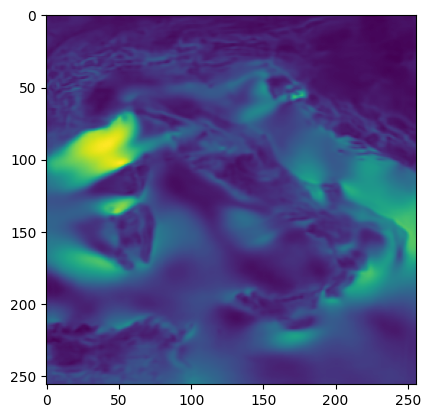

In [11]:
plt.imshow(tmp[4])

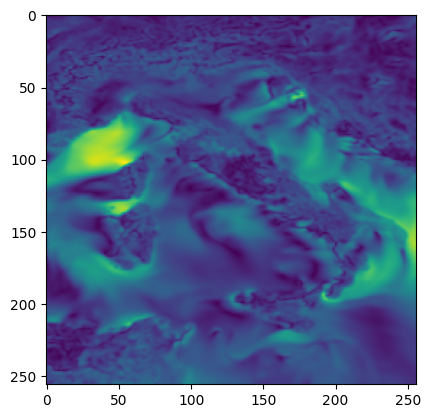

In [12]:
plt.imshow(sampout[4])

In [13]:
def print_results_unet(a,b,c):
    
    for i in range(a.shape[0]):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
        
        ax = axes[0]
        ax.imshow(a[i,:,:,-1], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("last low res")
        
        ax = axes[1]
        ax.imshow(c[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("predicted")

        ax = axes[2]
        ax.imshow(b[i,:,:], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title("ground truth")       

        plt.tight_layout()
        #plt.savefig("unet" + str(i) + ".png")
        plt.show()
        

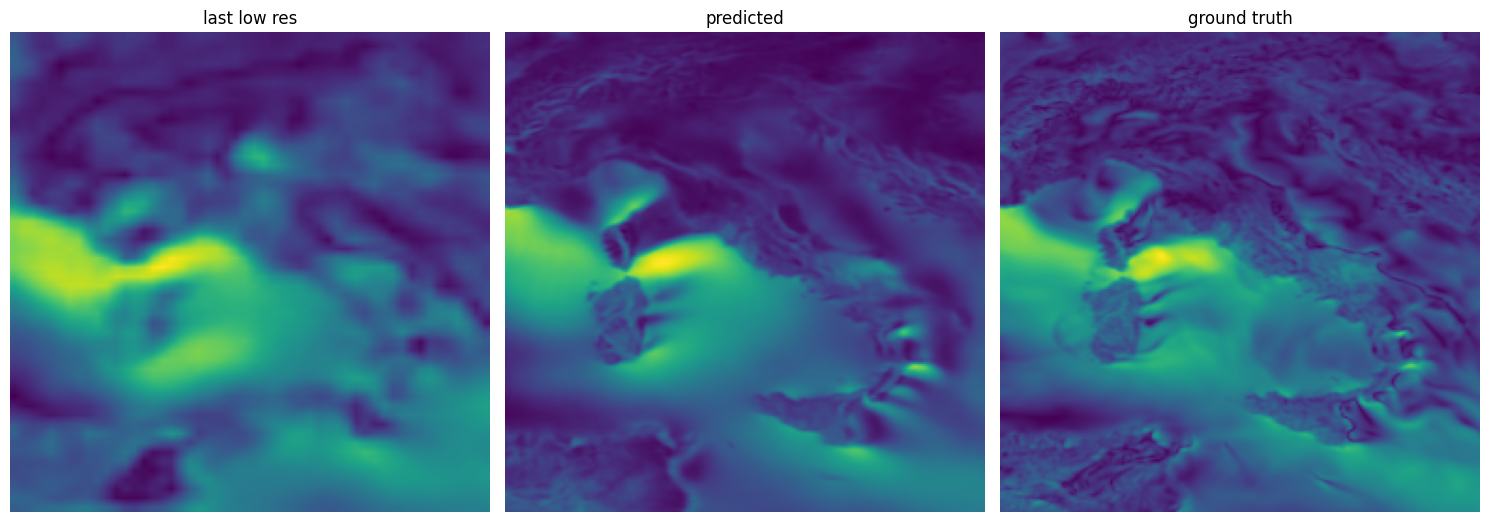

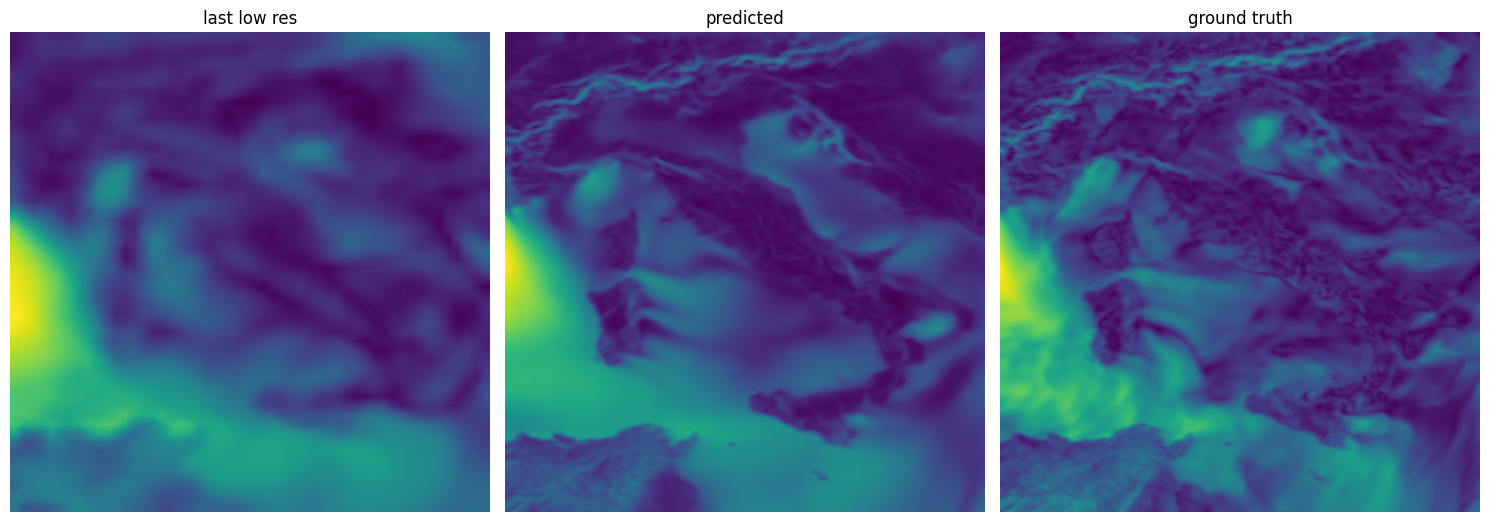

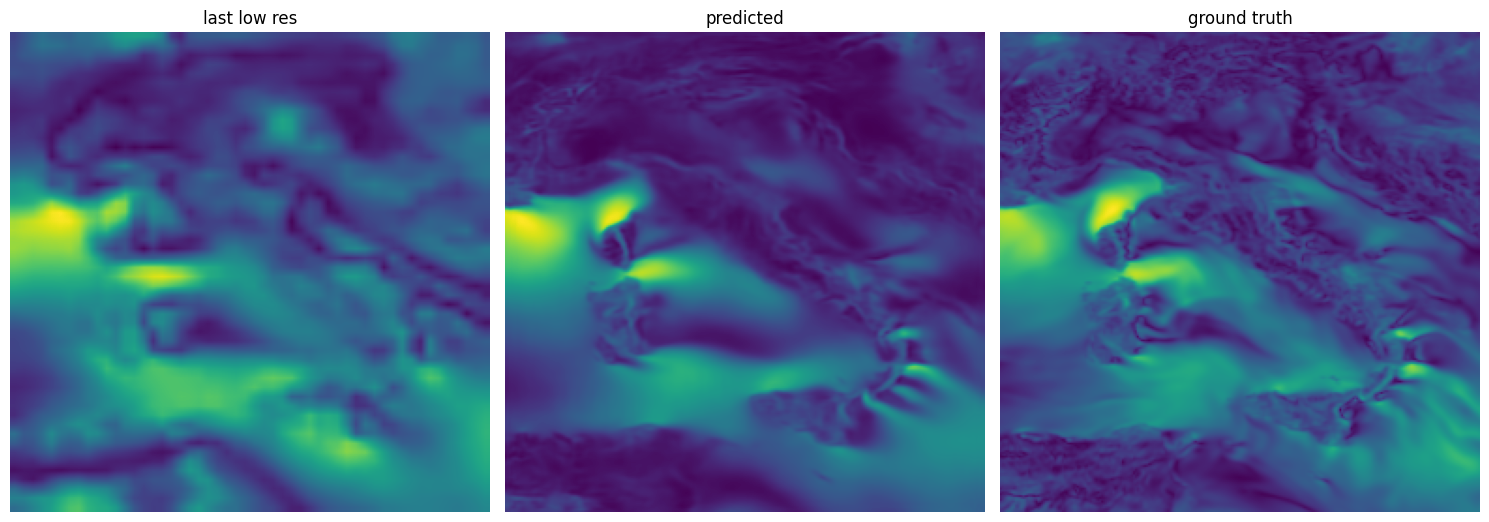

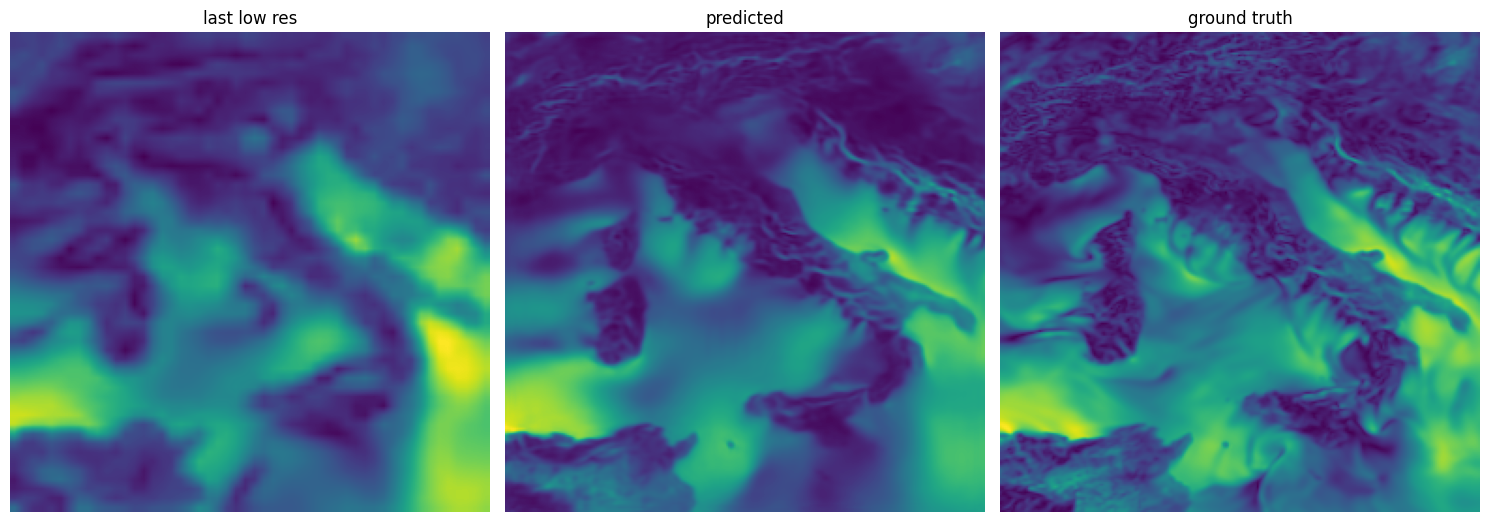

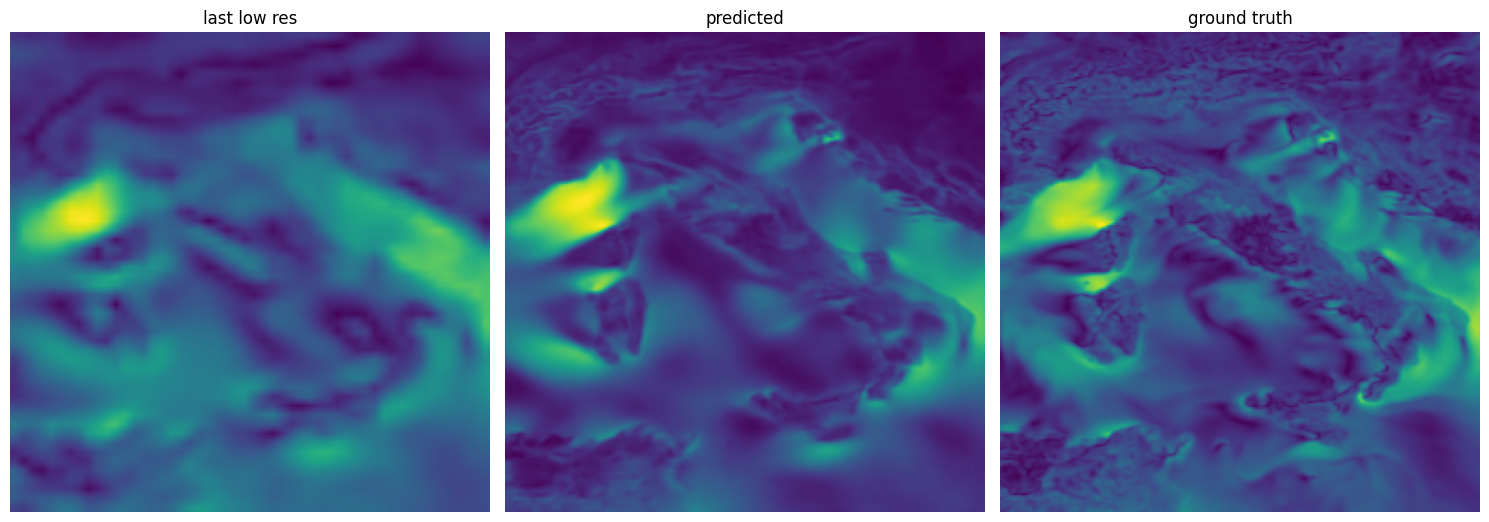

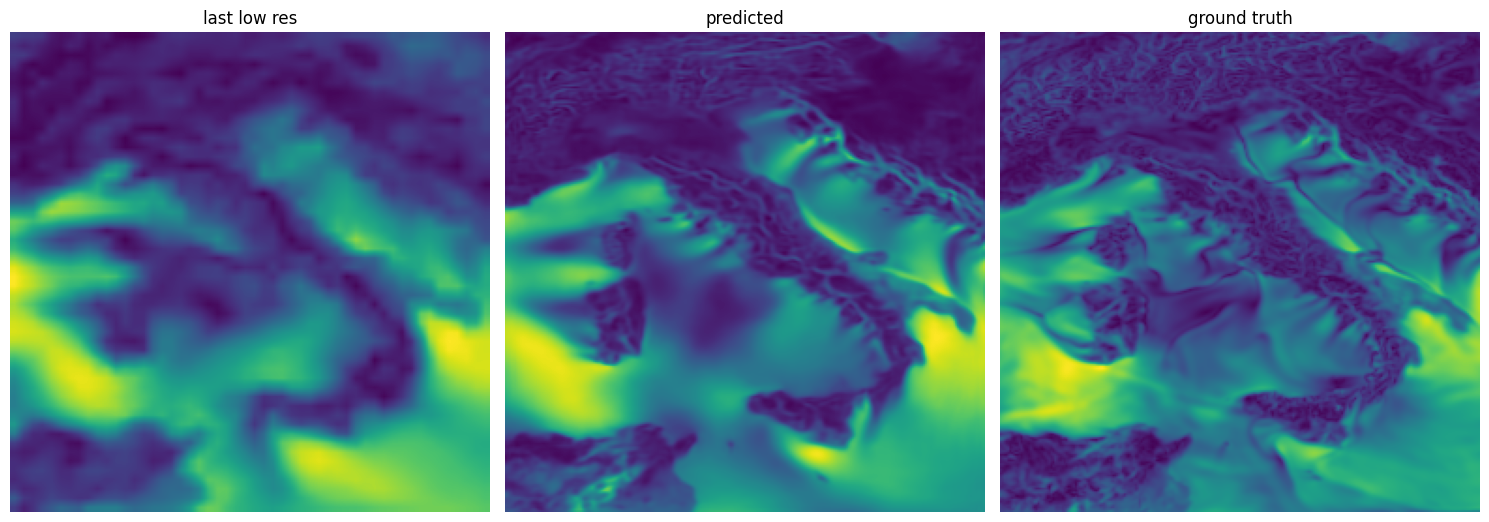

In [14]:
print_results_unet(sampin,sampout,tmp)

In [15]:
#np.save("./visualization_recap_data/unet",tmp)

## Evaluation

In [10]:
def experiment_unet(generator, n_iter=100):
    #define final mse array 
    #raw = np.zeros((91,32,256,256))
    #bilinear = np.zeros((91,32,256,256))
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = unet_model.predict(sampin)
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i] = batch_ssim(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-2]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-2],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-2],sampout)
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
        #raw[i] = np.squeeze(tmp)
        #bilinear[i] = sampin[:,:,:,-2]
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline#, raw, bilinear

In [12]:
import time
full_test_generator.counter_reset()
start_time = time.time()  # Capture the start time

full_test_generator2009.counter_reset()
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline = experiment_unet(full_test_generator2009,91)

end_time = time.time()  # Capture the end time
execution_time = end_time - start_time 

0


2024-01-09 12:14:32.083827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-01-09 12:14:32.410497: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 12:14:32.410849: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 12:14:32.410863: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-01-09 12:14:32.411134: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 12:14:32.411153: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 0s 18ms/step
5
1/1 [==============================] - 0s 20ms/step
10
1/1 [==============================] - 0s 17ms/step
15
1/1 [==============================] - 0s 17ms/step
20
1/1 [==============================] - 0s 17ms/step
25
1/1 [==============================] - 0s 18ms/step
30
1/1 [==============================] - 0s 17ms/step
35
1/1 [==============================] - 0s 19ms/step
40
1/1 [==============================] - 0s 22ms/step
45
1/1 [==============================] - 0s 17ms/step
50
1/1 [==============================] - 0s 17ms/step
55
1/1 [==============================] - 0s 22ms/step
60
1/1 [==============================] - 0s 21ms/step
65
1/1 [==============================] - 0s 22ms/step
70
1/1 [==============================] - 0s 17ms/step
75
1/1 [==============================] - 0s 18ms/step
80
1/1 [==============================] - 0s 19ms/step
85
1/1 [==============================] - 0s 17ms/step
90
1/1 [======

In [13]:
execution_time

146.68144154548645

In [80]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.7728539737156351   ssim baseline: 0.7120680397710939
psnrs: 29.24501191935172   psnrs_baseline: 26.678920945932934
mse: 0.0012778628558449137   mse baseline: 0.002385194862603757


In [14]:
print("ssim:", ssims.mean(), "  ssim baseline:", ssims_baseline.mean())

print("psnrs:", psnrs.mean(), "  psnrs_baseline:", psnrs_baseline.mean())

print("mse:", mses.mean(), "  mse baseline:", mses_baseline.mean())

ssim: 0.8190615287481442   ssim baseline: 0.7080940925839915
psnrs: 29.658312840456517   psnrs_baseline: 26.36268835918632
mse: 0.0011617062119265494   mse baseline: 0.0025665884435621526


In [81]:
np.save("numerical_results/unet2020_mses",mses)
#np.save("numerical_results/baseline2020_mses",mses_baseline)

np.save("numerical_results/unet2020_psnrs",psnrs)
#np.save("numerical_results/baseline2020_psnrs",psnrs_baseline)

np.save("numerical_results/unet2020_ssims",ssims)
#np.save("numerical_results/baseline2020_ssims",ssims_baseline)

## SSIMS maps

In [ ]:
# Experiment
def unet_ssimap_gen(generator, n_iter=100):
    #define final mse array 
    mses = np.zeros(n_iter)
    mses_baseline = np.zeros(n_iter)
    
    maps_log = np.zeros((n_iter, batch_size, 256,256))
    
    ssims = np.zeros(n_iter)
    psnrs = np.zeros(n_iter)
    
    ssims_baseline = np.zeros(n_iter)
    psnrs_baseline = np.zeros(n_iter)
    for i in range(n_iter):
        if(i%5 == 0):
            print(i)
        #select a random batch in the test set  
        sampin,sampout = generator.__getitem__(i)
        
        tmp = unet_model.predict(sampin)
        
        mse = np.mean( ((sampout-np.squeeze(tmp))**2))
        ssims[i], maps = batch_ssim_full(sampout,np.squeeze(tmp))
        psnrs[i] = batch_psnr(sampout,np.squeeze(tmp))
        
        mse_baseline = np.mean( ((sampin[:,:,:,-1]-sampout)**2))
        ssims_baseline[i] = batch_ssim(sampin[:,:,:,-1],sampout)
        psnrs_baseline[i] = batch_psnr(sampin[:,:,:,-1],sampout)
        
        maps_log[i] = maps
        #print(mse.shape)
        # add 3 relevant meteric values to array 
        mses_baseline[i] = mse_baseline
        mses[i] = mse
    # return average of all mses
    return mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline, maps_log

In [ ]:
mses, mses_baseline, psnrs, psnrs_baseline, ssims, ssims_baseline, maps = unet_ssimap_gen(test_unet_generator,800)

In [ ]:
maps = maps.reshape(3200,256,256)

In [ ]:
plt.imshow(maps.mean(axis=0))

In [ ]:
plt.imsave("mean ssim map.jpg", maps.mean(axis=0))

## Variance Analyis

In [181]:
def calculate_pixelwise_variance(images):
    # Calculate mean image
    mean_image = np.mean(images, axis=0)

    # Calculate variance
    variance = np.mean([(img - mean_image) ** 2 for img in images], axis=0)
    return variance

In [188]:
def variance_experiment(max_step = 20):
    ensemble_iter = 1
    for k in range(max_step):
        print("working with "+str(k + 1)+" steps")
        full_test_generator.counter_reset()
        variances = []
        mses = []
        ssims = []
        for i in range(10):
            test = full_test_generator.__getitem__(i)
            hist = np.copy(test)
            # define an accumulator variable for ensamble 
            res = np.zeros([batch_size,ensemble_iter, 256,256, 1])
            # run ensamble iterations
            for j in range(ensemble_iter):
                #make a copy of the random batch 
                sample = np.copy(test)

                #normalize sample before generation
                sample = model.normalizer(sample)
                # compute generation with 15 steps 
                tmp = model.generate2(np.copy(sample),k+1)
                #decoded = decoder.predict(tmp[:,:,:,-1], verbose = 0)
                # denormalize prediction
                #tmp = tmp * maxRtesr
                #print(decoded.shape)
                #save prediction in accumulator 
                res[:,j] = tmp[:,:,:,-1:] 
                #print(res.shape)
            variances.append(calculate_pixelwise_variance(res[0,:,:,:,0]).mean())
            average = np.mean(res,axis=1)
            mses.append(np.mean( ((test[:,:,:,-1]-average[:,:,:,-1])**2)))
            ssims.append(batch_ssim(test[:,:,:,-1],average[:,:,:,-1]))
        np.save("nonlinear_variance_studies/single_variance_steps"+str(k+1), variances)
        np.save("nonlinear_variance_studies/single_mses_steps"+str(k+1), mses)
        np.save("nonlinear_variance_studies/single_ssims_steps"+str(k+1), ssims)
            #print(calculate_pixelwise_variance(res[0,:,:,:,0]).mean())
            # average all predictions in the ensamble

In [186]:
def variance_printer(print_range = 3):
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_variance_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("Ensamble pixelwise variance")    
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_mses_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("MSES")
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("nonlinear_variance_studies/single_ssims_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("SSIMS")
    plt.legend()
    plt.show()

In [184]:
def variance_displayer(print_range = 3):
    variances_mean = []
    mses_mean = []
    ssim_mean = []
    print("VARIANCES")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_variance_steps"+str(i+1)+".npy")
        variances_mean.append(tmp.mean())
    print(variances_mean)
    print("MSES")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_mses_steps"+str(i+1)+".npy")
        mses_mean.append(tmp.mean())
    print(mses_mean)
    print("SSIMS")
    for i in range(print_range):
        tmp = np.load("nonlinear_variance_studies/single_ssims_steps"+str(i+1)+".npy")
        ssim_mean.append(tmp.mean())
    print(ssim_mean)   
    plt.plot(variances_mean,color = "r")
    plt.title("Variance")
    plt.show()
    plt.plot(mses_mean)
    plt.title("MSES")
    plt.show()
    plt.plot(ssim_mean,color = "green")
    plt.title("SSIMS")
    plt.show()

In [189]:
variance_experiment(20)

working with 1 steps
working with 2 steps
working with 3 steps
working with 4 steps
working with 5 steps
working with 6 steps
working with 7 steps
working with 8 steps
working with 9 steps
working with 10 steps
working with 11 steps
working with 12 steps
working with 13 steps
working with 14 steps
working with 15 steps
working with 16 steps
working with 17 steps
working with 18 steps
working with 19 steps
working with 20 steps


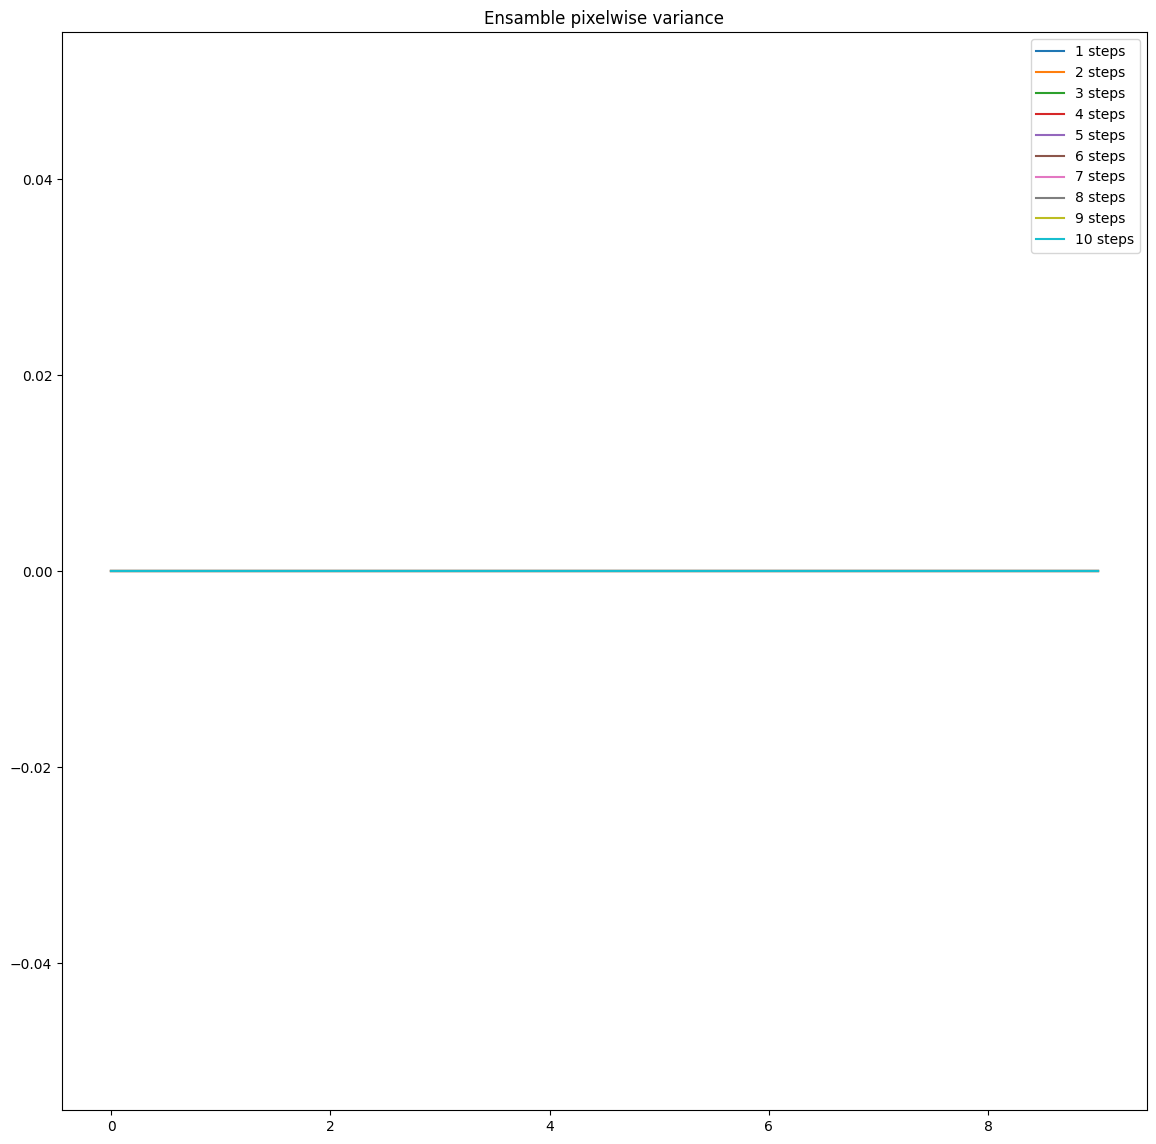

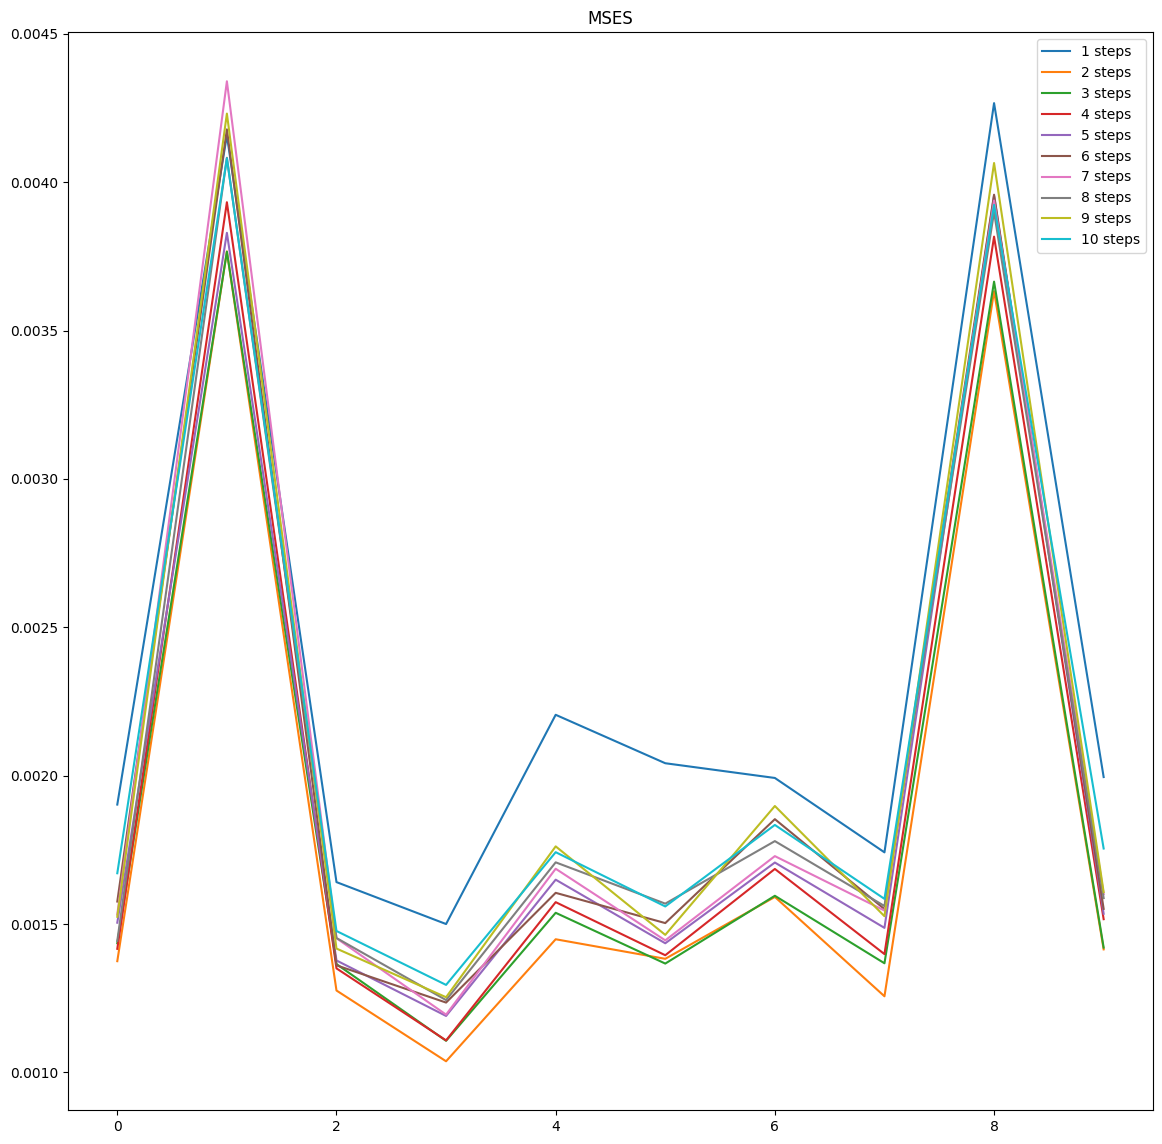

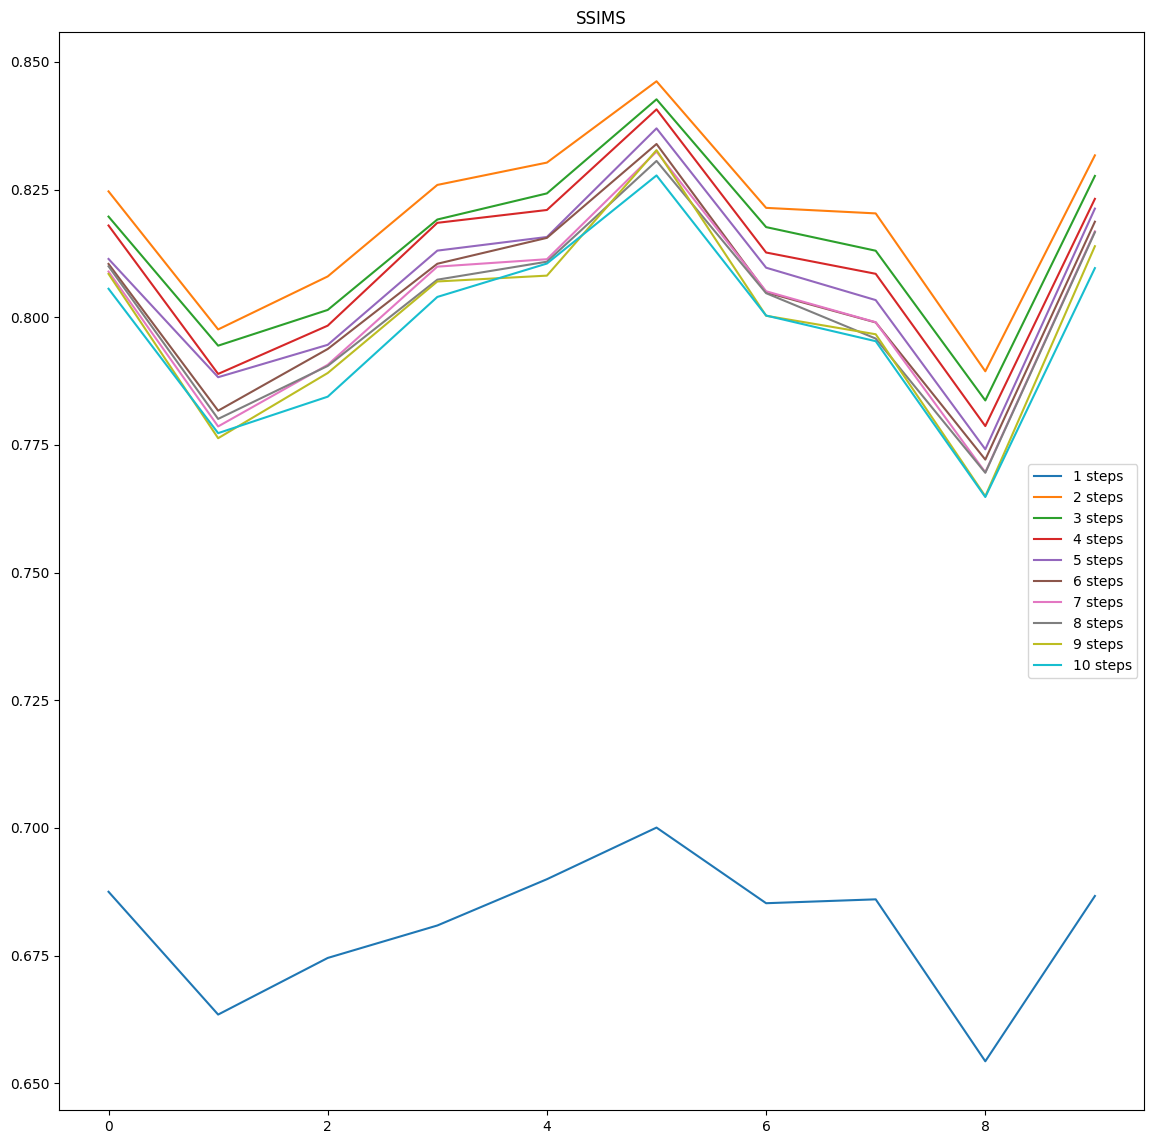

In [190]:
variance_printer(10)

VARIANCES
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MSES
[0.002344232753293918, 0.0018179209402618228, 0.0018623579225054035, 0.0019190848357186602, 0.001966708948115417, 0.00203687351841935, 0.002046148450341306, 0.0020323479055537716, 0.002074542952468256, 0.0020919005296525977, 0.0021197280037050337, 0.0021290142472447813, 0.002197903775714518, 0.002160757067766924, 0.0021392396586894995, 0.0022222690840840486, 0.002177196624131934, 0.0022619139601014688, 0.002243642061484321, 0.002224934230578136]
SSIMS
[0.6808600587245095, 0.8195524351000103, 0.8143687109126743, 0.8108466897612964, 0.806849205053185, 0.8040561441321813, 0.8022517443677211, 0.8016102096276679, 0.7997575284359328, 0.7979636446162932, 0.7970658675899063, 0.7976393523037026, 0.7949759447847546, 0.7944545494750404, 0.7942896118950167, 0.793996791158881, 0.7941921780588574, 0.7930527051073556, 0.7921474541494844, 0.7920069773887075]


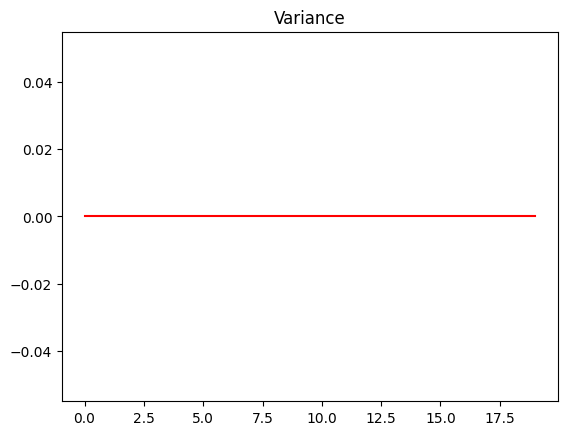

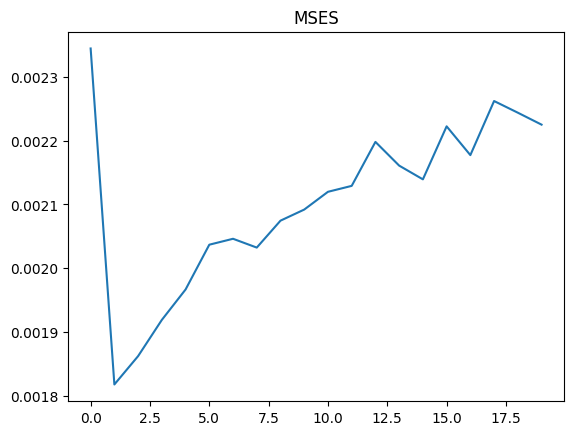

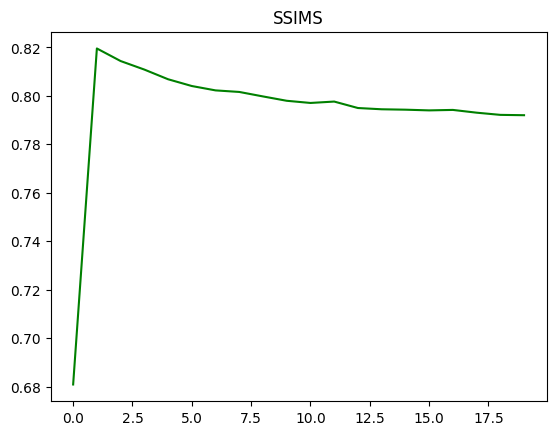

In [191]:
variance_displayer(20)

In [8]:
def variance_printer2(print_range = 3):
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/variance_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("Ensamble pixelwise variance")    
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/mses_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("MSES")
    plt.legend()
    plt.show()
    plt.figure(figsize=(14,14))
    for i in range(print_range):
        plt.plot(np.load("correct_variance_studies/ssims_steps"+str(i+1)+".npy"), label=str(i+1) + " steps")
    plt.title("SSIMS")
    plt.legend()
    plt.show()

In [9]:
def variance_displayer2(print_range = 3):
    variances_mean = []
    mses_mean = []
    ssim_mean = []
    print("VARIANCES")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/variance_steps"+str(i+1)+".npy")
        variances_mean.append(tmp.mean())
    print(variances_mean)
    print("MSES")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/mses_steps"+str(i+1)+".npy")
        mses_mean.append(tmp.mean())
    print(mses_mean)
    print("SSIMS")
    for i in range(print_range):
        tmp = np.load("correct_variance_studies/ssims_steps"+str(i+1)+".npy")
        ssim_mean.append(tmp.mean())
    print(ssim_mean)   
    plt.plot(variances_mean,color = "r")
    plt.title("Variance")
    plt.show()
    plt.plot(mses_mean)
    plt.title("MSES")
    plt.show()
    plt.plot(ssim_mean,color = "green")
    plt.title("SSIMS")
    plt.show()

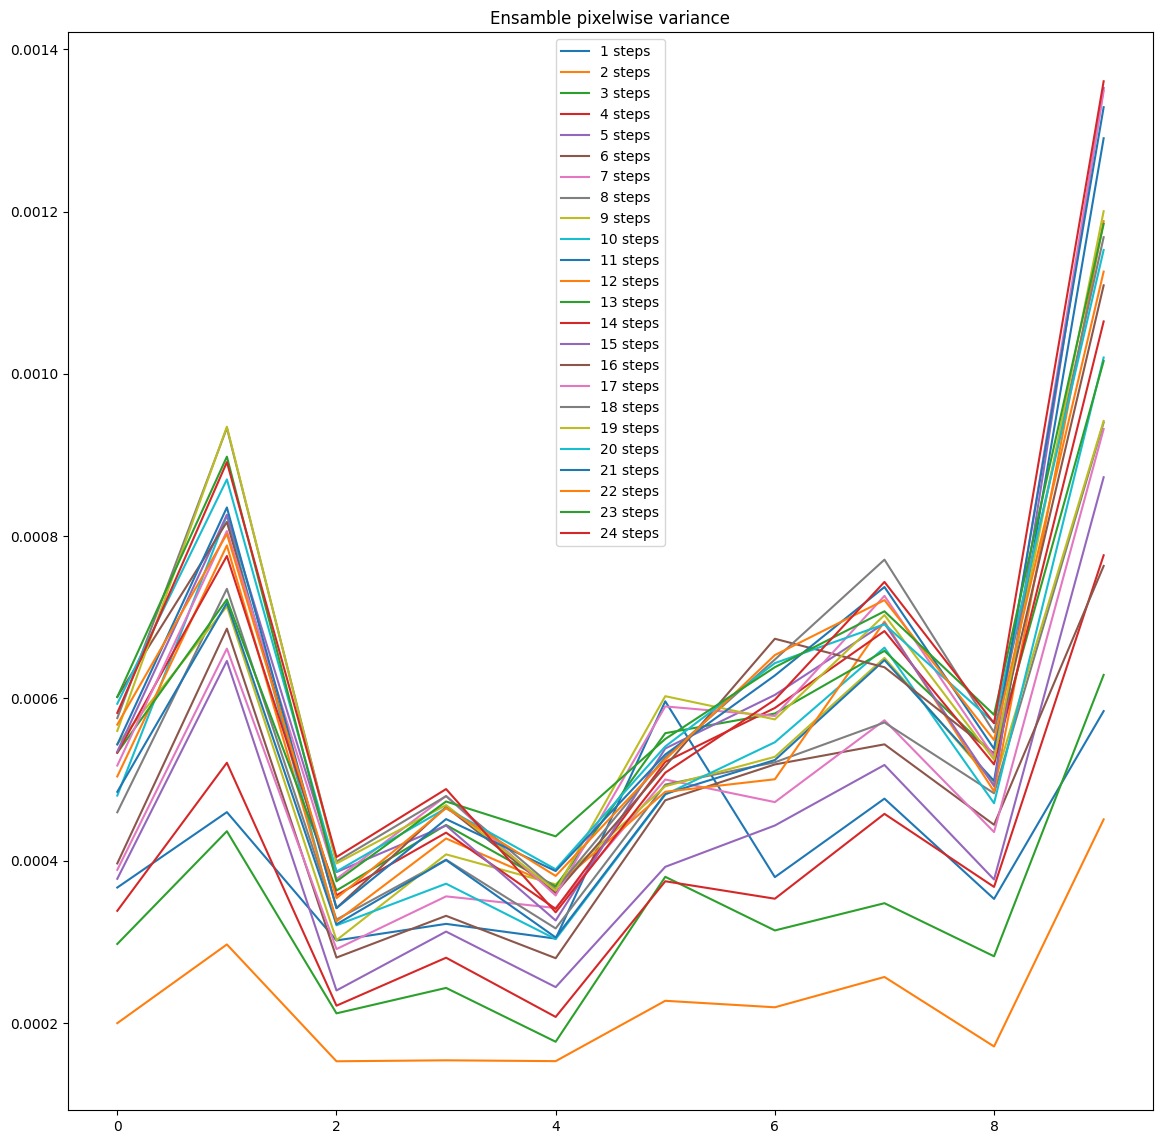

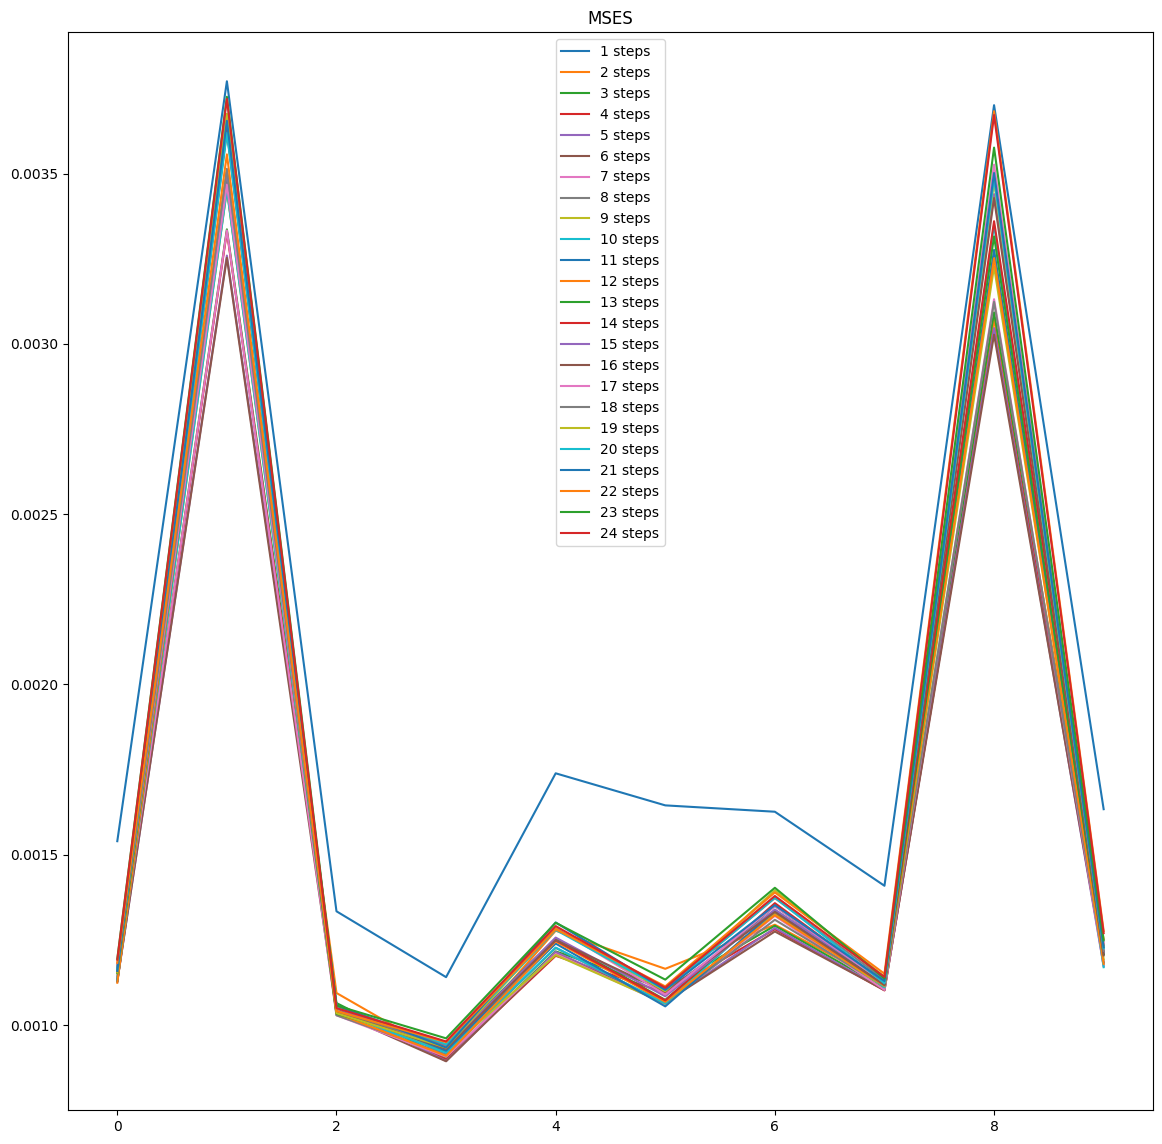

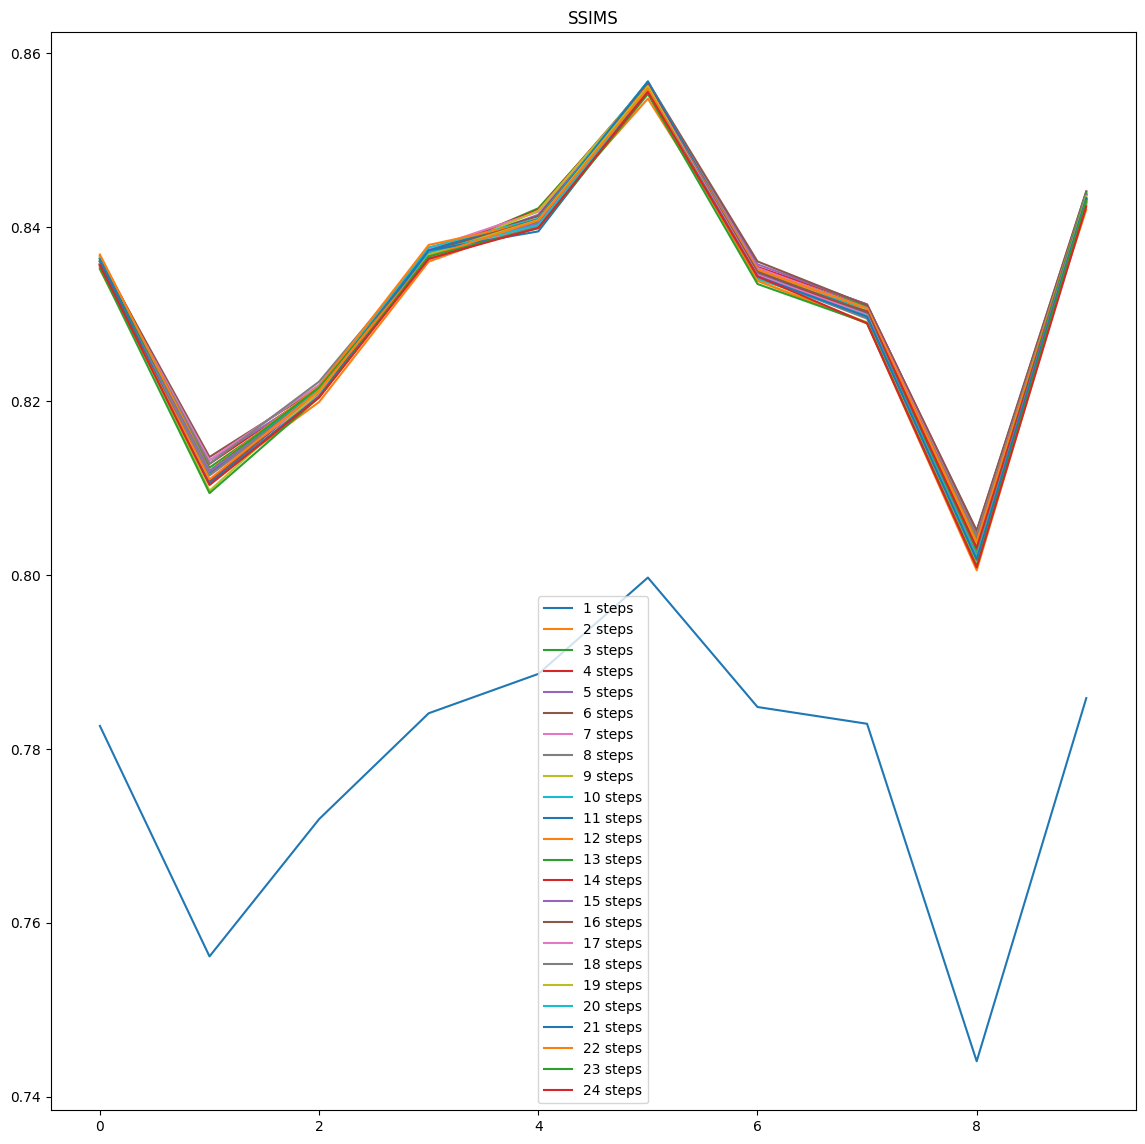

In [10]:
variance_printer2(24)

VARIANCES
[0.0004145389386215126, 0.00022826324257941804, 0.0003319485756641882, 0.00038985993045542717, 0.00044248712659367714, 0.00047198755542458544, 0.0004952457154392997, 0.0005249313252549384, 0.0005445409796394494, 0.0005482874798101757, 0.0005673304247513516, 0.0005767431807498664, 0.0005774871252614669, 0.0005818144224254244, 0.0006196353535218822, 0.0006057915500063674, 0.0006310203106024536, 0.0006426086720699526, 0.0006328466857649229, 0.0006303158849483423, 0.0006322185962503753, 0.0006144686267845534, 0.0006438291593648893, 0.0006483680534937073]
MSES
[0.001953941472421337, 0.0015817832792835245, 0.0015470235004274868, 0.001535027643708935, 0.0015227734327587805, 0.0015175772173992871, 0.0015408343313879718, 0.0015562397437600298, 0.0015671249214607125, 0.0015815785088526622, 0.001583324325568154, 0.001575618252613243, 0.0015951619488194784, 0.0016159997515893597, 0.0016116277502814206, 0.0016181210614468438, 0.0016257958246093899, 0.0016262906352716828, 0.001642477075947

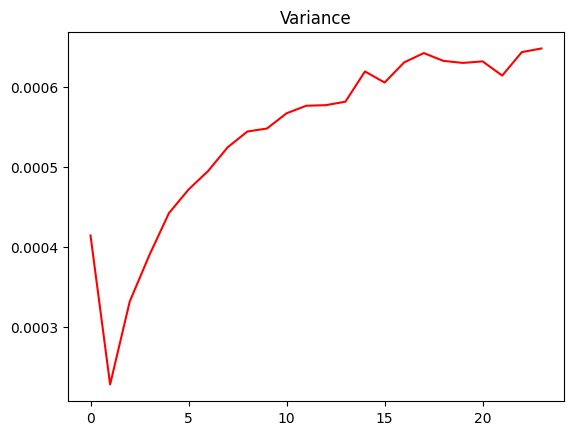

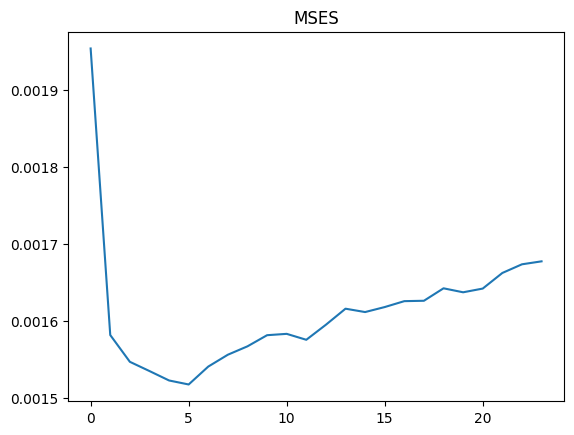

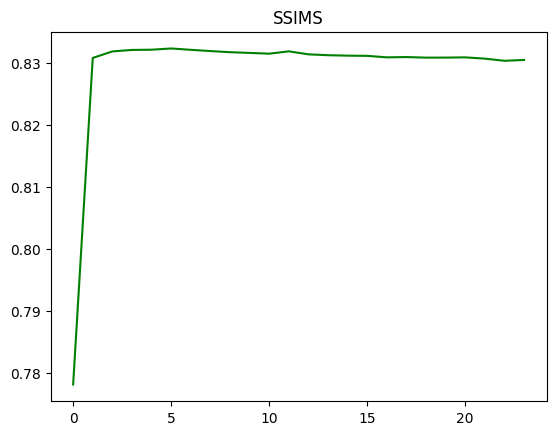

In [11]:
variance_displayer2(24)

## Extras

In [ ]:
def plot_sequence(data, start_idx=0, num_imgs=5):
    fig, axes = plt.subplots(1, num_imgs, figsize=(15, 3))
    
    for i in range(num_imgs):
        ax = axes[i]
        ax.imshow(data[start_idx + i], cmap='viridis')  # Use appropriate colormap for your data
        ax.axis('off')
        ax.set_title(f"Index {start_idx + i}")

    plt.tight_layout()
    plt.show()

# Plotting 5 contiguous images starting from index 10 (for example)
plot_sequence(high_res_dataset, start_idx=33, num_imgs=5)
plot_sequence(low_res_dataset, start_idx=33, num_imgs=5)